In [1]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
from eli5.sklearn import PermutationImportance
from nltk.corpus import stopwords
from string import punctuation

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [4]:
data = pd.read_csv('/gdrive/My Drive/exam/jigsaw-toxic-comment-train.csv.zip')

### 1. Описательный анализ данных с привязкой к целевой переменной (toxic) и 2 другим дополнительным колонкам (как минимум 5 статистик на каждую группу) - 1.5 балл

In [5]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
data.shape

(223549, 8)

In [7]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


In [18]:
data.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
toxic,1.000000,0.289325,0.697349,0.161360,0.666690,0.281483,-0.060568,-0.058667,0.085272,-0.052055,-0.086144,-0.019540,-0.060174,-0.008683,-0.020370,-0.086951
severe_toxic,0.289325,1.000000,0.375318,0.131472,0.350608,0.212644,0.018164,0.016976,0.141318,0.023280,-0.016058,-0.004171,0.018508,-0.002664,0.033514,-0.019355
obscene,0.697349,0.375318,1.000000,0.143005,0.745039,0.296548,-0.044486,-0.043736,0.083071,-0.038371,-0.068162,-0.014201,-0.044180,-0.006571,-0.014393,-0.070114
threat,0.161360,0.131472,0.143005,1.000000,0.151066,0.115382,-0.006950,-0.005417,0.038689,-0.000139,-0.018497,-0.005721,-0.006887,-0.001197,0.012888,-0.018352
insult,0.666690,0.350608,0.745039,0.151066,1.000000,0.348853,-0.046247,-0.044753,0.074848,-0.040528,-0.067899,-0.015110,-0.045966,-0.006407,-0.018216,-0.068965
identity_hate,0.281483,0.212644,0.296548,0.115382,0.348853,1.000000,-0.012629,-0.013804,0.058796,-0.012545,-0.027249,-0.004856,-0.012474,-0.002643,-0.006628,-0.027754
text_len,-0.060568,0.018164,-0.044486,-0.006950,-0.046247,-0.012629,1.000000,0.985277,0.368018,0.961694,0.965098,0.257665,0.996202,0.112487,0.605927,0.959113
text_len_tokens,-0.058667,0.016976,-0.043736,-0.005417,-0.044753,-0.013804,0.985277,1.000000,0.351443,0.949748,0.952620,0.223633,0.980966,0.117317,0.547440,0.948272
number_of_caps,0.085272,0.141318,0.083071,0.038689,0.074848,0.058796,0.368018,0.351443,1.000000,0.344361,0.153055,0.093762,0.369616,0.007208,0.224448,0.151283
number_of_nonalphanum,-0.052055,0.023280,-0.038371,-0.000139,-0.040528,-0.012545,0.961694,0.949748,0.344361,1.000000,0.903704,0.266320,0.953602,0.158840,0.739119,0.898460


In [10]:
toxic_positive = data[data['toxic']==1]
toxic_positive.shape

(21384, 8)

In [11]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

In [14]:
stops = stopwords.words('english')

In [15]:
data['text_len'] = data['comment_text'].apply(len) #длина текста
data['text_len_tokens'] = data['comment_text'].apply(lambda x: len(x.split())) #количество токенов
data['number_of_caps'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch.isupper()])) #количество слов с заглавной буквы
data['number_of_nonalphanum'] = data['comment_text'].apply(lambda x: len([ch for ch in x if not ch.isalnum()])) #количество букв
data['number_of_lows'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch.islower()])) #количество строчных букв
data['number_of_digits'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch.isdigit()])) #количество цифр
data['number_of_ascii'] = data['comment_text'].apply(lambda x: len([ch for ch in x if is_ascii(ch)])) #количество ascii символов
data['number_of_nonascii'] = data['comment_text'].apply(lambda x: len([ch for ch in x if not is_ascii(ch)])) #количество non-ascii символов
data['number_of_punctuation'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch in punctuation])) #количество знаков пунктуации
data['number_of_stops'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch in stops])) #количество стоп-слов

In [16]:
data.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,43,17,52,186,9,264,0,10,84
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,17,8,29,65,10,112,0,12,29
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,42,4,47,182,0,233,0,6,99


### Toxic/Non-toxic

In [17]:
data.groupby('toxic')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
toxic,,,,,,,,,,
0,402.691178,68.415161,14.484189,89.072456,294.922009,3.248698,400.972142,1.719036,16.974704,141.799609
1,280.604097,48.573466,44.689675,65.266741,168.618921,1.995885,280.409512,0.194585,14.257202,80.432941


### Описание TBA

### Severe_toxic/Non-severe_toxic

In [19]:
data.groupby('severe_toxic')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
severe_toxic,,,,,,,,,,
0,389.999386,66.358270,15.988131,86.500630,283.491852,3.136258,388.413228,1.586158,16.591014,136.307514
1,505.456677,84.462793,173.841998,120.072375,209.248726,2.293068,505.345566,0.111111,30.690112,93.232926


### Описание TBA

### Obscene/Non-obscene

In [20]:
data.groupby('obscene')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
obscene,,,,,,,,,,
0,397.332876,67.559707,15.299590,88.032052,289.883993,3.193029,395.678353,1.654523,16.850087,139.417163
1,280.951730,48.362109,53.490033,65.257743,160.178748,2.011367,280.794481,0.157249,14.358072,75.193822


### Описание TBA

### Threat/Non-threat

In [21]:
data.groupby('threat')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
threat,,,,,,,,,,
0,391.241807,66.547128,17.149430,86.796312,283.283766,3.134856,389.665157,1.576649,16.686637,136.141282
1,316.910015,56.825835,89.866473,86.460087,139.383164,1.188679,316.448476,0.461538,25.809869,67.416546


### Описание TBA

### Insult/Non-insult

In [23]:
data.groupby('insult')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
insult,,,,,,,,,,
0,397.340234,67.544536,15.573931,88.053302,289.597522,3.194615,395.690669,1.649565,16.879710,139.233245
1,272.206476,47.227176,51.163393,63.174452,155.965057,1.894197,272.066879,0.139597,13.617569,73.897381


### Описание TBA

### Identity_hate/Non-identity_hate

In [24]:
data.groupby('identity_hate')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
identity_hate,,,,,,,,,,
0,391.744793,66.651428,16.774599,86.960259,283.989184,3.137812,390.158234,1.586559,16.740187,136.492779
1,314.438829,52.473784,80.022201,69.538498,162.665092,2.192253,314.261691,0.177137,14.054795,77.008503


### Описание TBA

### 2. Бейзлайн модель из sklearn (векторайзер + модель) с отбором признаков (через l1 регуляризацию, на глаз через анализ важных параметров или через permutation importance) - 2 балл

In [ ]:
X = data['comment_text']
y = data['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
count_vect = CountVectorizer()

In [ ]:
X_train = count_vect.fit_transform(X_train)
X_train.shape

(149777, 207901)

In [ ]:
X_test = count_vect.transform(X_test)
X_test.shape

(73772, 207901)

In [ ]:
clf = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     66765
           1       0.80      0.62      0.70      7007

    accuracy                           0.95     73772
   macro avg       0.88      0.80      0.83     73772
weighted avg       0.95      0.95      0.95     73772



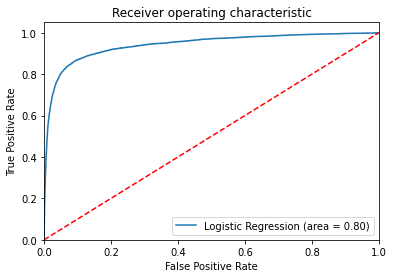

In [ ]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. 